# Practica 4, LSTM-GRU: DISCRETA

# Sentiment Analysis (LSTM vs. GRU)

## Preparación de ambiente

### Carga de módulos

In [2]:
# Data Wrnagling
import re
import numpy as np
import pandas as pd

# Data visualization
from PIL import Image
import cufflinks as cf
import matplotlib.pyplot as plt
from wordcloud import ImageColorGenerator
from wordcloud import WordCloud, STOPWORDS

# Modeling
from keras import metrics
from keras.layers import GRU
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Embedding
from keras.models import Sequential
from keras.layers import SpatialDropout1D
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Preprocessing
import unicodedata
from bs4 import BeautifulSoup
from nltk import word_tokenize
from nltk.corpus import stopwords
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# Model performance
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score

cf.go_offline()

### Funciones relevantes

In [3]:
def freq_discrete(df, feat_disc=[]):
    for var in feat_disc:
        print(f"\nFeature: {var}\n")
        aux = df[var].fillna("Missing").value_counts().to_frame()
        aux[f"{var}_cumsum"] = aux[var].cumsum()
        aux["perc"] = aux[var] / len(df)
        aux["cumsum"] = aux["perc"].cumsum()
        aux[var] = aux[var].apply(lambda x: "{:,.0f}".format(x))
        aux[f"{var}_cumsum"] = aux[f"{var}_cumsum"].apply(
            lambda x: "{:,.0f}".format(x))
        aux["perc"] = aux["perc"].apply(lambda x: "{:,.2%}".format(x))
        aux["cumsum"] = aux["cumsum"].apply(lambda x: "{:,.2%}".format(x))
        aux.columns = ["Frequency", "Accumulated frequency",
                       "Percentage", "Accumulated percentage"]
        display(aux)

In [4]:
def clean_text(text, pattern="[^a-zA-Z0-9 ]"):
    cleaned_text = unicodedata.normalize('NFD', text).encode('ascii', 'ignore')
    cleaned_text = re.sub(pattern, " ", cleaned_text.decode("utf-8"), flags=re.UNICODE)
    cleaned_text = u' '.join(cleaned_text.lower().split())
    return cleaned_text

In [5]:
def get_wordcloud(text, mask_path, font_path):
    mask = np.array(Image.open(mask_path))
    mask_colors = ImageColorGenerator(mask)
    wc = WordCloud(stopwords=STOPWORDS, font_path=font_path, 
                   background_color="white", max_words=2000,
                   max_font_size=100, random_state=42,
                   width=mask.shape[1], height=mask.shape[0], color_func=mask_colors)
    wc.generate(text)
    plt.figure(figsize=(50, 10))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis('off')
    plt.show()

## Data Wrangling

### Carga de datos

In [44]:
df = pd.read_csv("amazon_train.csv", error_bad_lines=False)

In [45]:
df

,asin,name,rating,date,verified,title,body,helpfulVotes,review_id
0,B07Q6ZNJNT,Robert Baratheon,5,"May 30, 2019",True,Hermoso diseño y muy rapido,Me llego hoy y es justo lonque esperaba de ver...,18.0,14945
1,B07C6FCC8G,McMan,5,"July 15, 2018",False,Prefer it to my iPhone x..,Best phone I've ever had. My iPhone x is sitti...,NaN,8989
2,B07HD3QC65,JASMINE WIN,3,"February 21, 2019",True,just ok,I dont like this phone. this phone is not too ...,NaN,50888
3,B07P8MQHSH,Hermione,1,"December 13, 2019",True,Perfect to BRICK in 2 days flat - light usage,"I bought this phone NEW from Amazon, set it up...",2.0,12734
4,B014GCG150,Monique,3,"December 20, 2016",True,SIM CARD TROUBLE,THE SIM CARD I AM USING IS TOO BIG GOING TO HA...,NaN,20622
...,...,...,...,...,...,...,...,...,...
50984,B07C2VFMN2,Amazon Customer,1,"September 10, 2019",True,DO NOT BUY THIS PHONE OR ANY MOTOROLA,I started with a MotoG4 - it lasted over a yea...,1.0,18843
50985,B00F2SKPIM,Amazon Customer,1,"August 3, 2017",True,One Star,phone was listed as stolen could not be turn o...,NaN,38789
50986,B0787V183F,David,5,"November 11, 2019",True,Very good phone.,Exactly as advertised. It's obvious that it's ...,1.0,61502
50987,B002WTC1NG,Sammie W Timmons,4,"November 27, 2014",True,Four Stars,Works as advertised.,NaN,9483


### EDA

In [46]:
df = df[['review_id','body','rating']]

In [47]:
df

,review_id,body,rating
0,14945,Me llego hoy y es justo lonque esperaba de ver...,5
1,8989,Best phone I've ever had. My iPhone x is sitti...,5
2,50888,I dont like this phone. this phone is not too ...,3
3,12734,"I bought this phone NEW from Amazon, set it up...",1
4,20622,THE SIM CARD I AM USING IS TOO BIG GOING TO HA...,3
...,...,...,...
50984,18843,I started with a MotoG4 - it lasted over a yea...,1
50985,38789,phone was listed as stolen could not be turn o...,1
50986,61502,Exactly as advertised. It's obvious that it's ...,5
50987,9483,Works as advertised.,4


In [48]:
df['rating'].value_counts(1)

5    0.557434
1    0.187354
4    0.127577
3    0.070035
2    0.057601
Name: rating, dtype: float64

In [49]:
freq_discrete(df, ["rating"])


Feature: rating



,Frequency,Accumulated frequency,Percentage,Accumulated percentage
5,"28,423","28,423",55.74%,55.74%
1,"9,553","37,976",18.74%,74.48%
4,"6,505","44,481",12.76%,87.24%
3,"3,571","48,052",7.00%,94.24%
2,"2,937","50,989",5.76%,100.00%


In [50]:
df["rating"].value_counts(dropna=False).iplot(kind="bar")

### Análisis de texto

In [51]:
df['body'] = df['body'].astype(str)

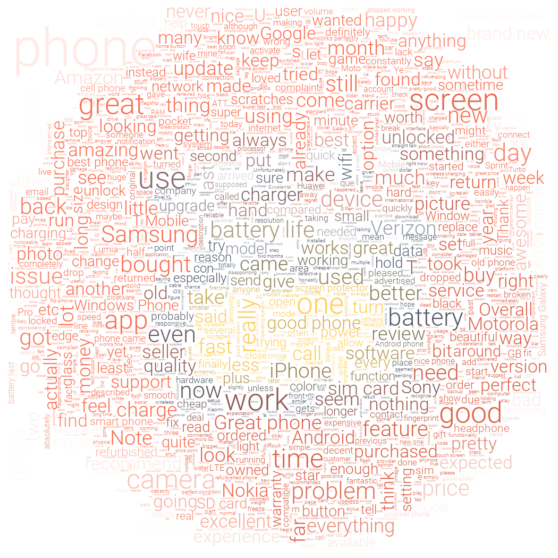

In [52]:
get_wordcloud(text = " ".join(df["body"].sample(frac = 0.1)), mask_path="movie-icon-png-2.jpg", font_path="Roboto-Light.ttf")

In [53]:
index = np.random.choice(df.index)

In [54]:
index

22858

In [55]:
df.loc[index, "body"]

'The phone arrived two days ago, I live in Costa Rica in Central America, when I put the sim worked the phone as I need the unlock code. appreciate it if you can give me!'

### Limpieza de texto

In [56]:
bs = BeautifulSoup(df.loc[index, "body"])

In [57]:
bs.prettify()

'<html>\n <body>\n  <p>\n   The phone arrived two days ago, I live in Costa Rica in Central America, when I put the sim worked the phone as I need the unlock code. appreciate it if you can give me!\n  </p>\n </body>\n</html>'

In [58]:
BeautifulSoup(bs.prettify()).text

'\n\n\n   The phone arrived two days ago, I live in Costa Rica in Central America, when I put the sim worked the phone as I need the unlock code. appreciate it if you can give me!\n  \n\n'

In [59]:
df["body"] = df["body"].map(lambda x: BeautifulSoup(BeautifulSoup(x).prettify()).text)

c:\users\jesus\onedrive\jss\diplomado\lib\site-packages\bs4\__init__.py:417: MarkupResemblesLocatorWarning:

"https://www.amazon.com/gp/product/B01M6749UP/ref=oh_aui_detailpage_o01_s00?ie=UTF8&psc=1" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.

c:\users\jesus\onedrive\jss\diplomado\lib\site-packages\bs4\__init__.py:417: MarkupResemblesLocatorWarning:

"https://www.amazon.com/dp/B01CJU9BBM/ref=cm_cr_ryp_prd_ttl_sol_0" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.



In [60]:
df["body"] = df["body"].map(clean_text)

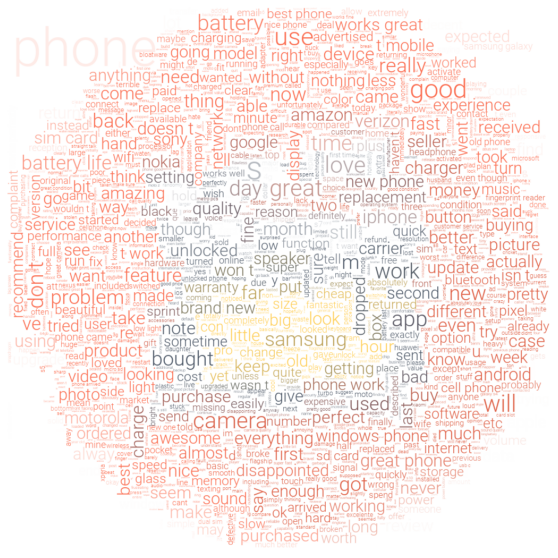

In [61]:
get_wordcloud(text = " ".join(df["body"].sample(frac = 0.1)), mask_path="./movie-icon-png-2.jpg", font_path="./Roboto-Light.ttf")

In [62]:
aux = pd.DataFrame(df['body'].value_counts())

In [63]:
aux.head(50)

,body
good,329
great phone,287
love it,194
great,162
excellent,161
excelente,158
very good,142
perfect,108
good phone,88
works great,83


### Limpieza de texto

In [64]:
stop_words = [clean_text(x) for x in STOPWORDS.union("will")]

In [65]:
df["body"] = df["body"].map(lambda sentence: " ".join([word for word in sentence.split() if word not in stop_words]))

In [66]:
df["body"].str.split().map(lambda lista: [x for x in lista if x not in stop_words]).str.join(" ")

0        llego hoy y es justo lonque esperaba de verdad...
1        best phone ve iphone x sitting drawer everythi...
2        dont phone phone havey screen big enough batte...
3        bought phone new amazon set used 2 days charge...
4        sim card using big going go phone dealer try r...
                               ...                        
50984    started motog4 lasted year needed new phone go...
50985               phone listed stolen turn return seller
50986    exactly advertised s obvious s refurbed great ...
50987                                     works advertised
50988    ordered use jamaica works great everything pac...
Name: body, Length: 50989, dtype: object

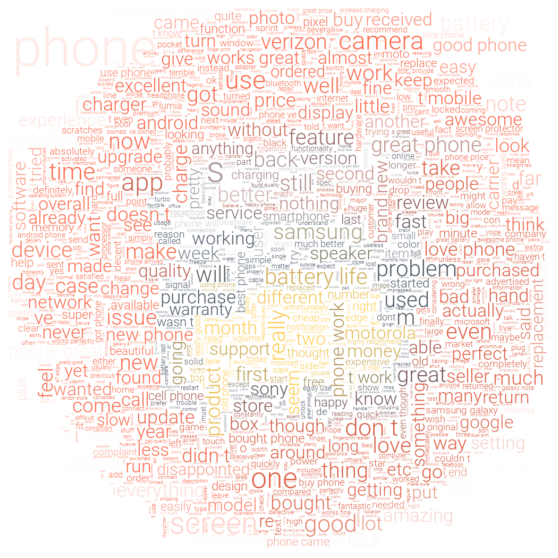

In [67]:
get_wordcloud(text = " ".join(df["body"].sample(frac = 0.1)), mask_path="./movie-icon-png-2.jpg", font_path="./Roboto-Light.ttf")

### Vectorización

In [68]:
df["body"].str.split().str.len().iplot(kind="hist")

In [69]:
df["body"].str.split().str.len().describe([x/10 for x in range(10)])

count    50989.000000
mean        29.425562
std         63.625710
min          0.000000
0%           0.000000
10%          2.000000
20%          4.000000
30%          6.000000
40%          9.000000
50%         12.000000
60%         17.000000
70%         24.000000
80%         37.000000
90%         65.000000
max       3161.000000
Name: body, dtype: float64

In [70]:
MAX_NB_WORDS = 50989
MAX_SEQUENCE_LENGTH = 200
EMBEDDING_DIM = 100

In [71]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['body'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 30782 unique tokens.


In [72]:
X = tokenizer.texts_to_sequences(df['body'].values)

### Padding

In [73]:
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (50989, 200)


In [74]:
X[0]

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,

In [75]:
X[-1]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

### Preparación de la target

In [78]:
df['rating'] = pd.Categorical(df['rating'])
df['rating'] = df['rating'].cat.codes
# Turn response variable into one-hot response vector
y = to_categorical(df['rating'])

In [79]:
y

array([[0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.]], dtype=float32)

### Train-test split

In [80]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123, test_size=0.3, shuffle=True,stratify = y)

## Modelado

### LSTM

#### Arquitectura del modelo

In [81]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2, activation="tanh"))
model.add(Dense(100, activation="relu"))
model.add(Dense(5, activation='softmax'))

In [82]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [83]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 100)          5098900   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 200, 100)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               80400     
_________________________________________________________________
dense (Dense)                (None, 100)               10100     
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 505       
Total params: 5,189,905
Trainable params: 5,189,905
Non-trainable params: 0
_________________________________________________________________


#### Callbacks

In [84]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=15, min_delta=0.0001)

In [85]:
checkpoint = ModelCheckpoint('models/LSTM/model_{val_accuracy:.3f}.h5',
                             save_best_only=True,
                             save_weights_only=False,
                             monitor='val_accuracy')

#### Entrenamiento

In [86]:
history = model.fit(X_train, y_train, epochs=10, batch_size=1024, callbacks=[early_stopping, checkpoint], validation_data=(X_test, y_test))

Epoch 1/10
35/35 [==============================] - 152s 4s/step - loss: 1.4043 - accuracy: 0.5205 - val_loss: 1.1604 - val_accuracy: 0.5607
Epoch 2/10
35/35 [==============================] - 154s 4s/step - loss: 1.1094 - accuracy: 0.5859 - val_loss: 0.9103 - val_accuracy: 0.6828
Epoch 3/10
35/35 [==============================] - 171s 5s/step - loss: 0.8664 - accuracy: 0.6915 - val_loss: 0.8424 - val_accuracy: 0.6997
Epoch 4/10
35/35 [==============================] - 183s 5s/step - loss: 0.7716 - accuracy: 0.7150 - val_loss: 0.8241 - val_accuracy: 0.7043
Epoch 5/10
35/35 [==============================] - 192s 6s/step - loss: 0.7173 - accuracy: 0.7296 - val_loss: 0.8222 - val_accuracy: 0.7014
Epoch 6/10
35/35 [==============================] - 200s 6s/step - loss: 0.6602 - accuracy: 0.7565 - val_loss: 0.8405 - val_accuracy: 0.7038
Epoch 7/10
35/35 [==============================] - 205s 6s/step - loss: 0.6147 - accuracy: 0.7751 - val_loss: 0.8668 - val_accuracy: 0.6954
Epoch 8/10
35

## EVALUATE

In [87]:
loss, acc = model.evaluate(X_test, y_test)

479/479 [==============================] - 18s 37ms/step - loss: 0.9957 - accuracy: 0.68250s - loss: 0.9953 - 


In [88]:
results = pd.DataFrame(data = zip(history.history["loss"], history.history["val_loss"], history.history["accuracy"], history.history["val_accuracy"]), columns=["loss", "val_loss", "accuracy", "val_accuracy"])

In [89]:
results.iplot()

### GRU

In [90]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(GRU(100, dropout=0.2, recurrent_dropout=0.2, activation="tanh"))
model.add(Dense(100, activation="relu"))
model.add(Dense(5, activation='sigmoid'))

In [91]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [92]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 100)          5098900   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 200, 100)          0         
_________________________________________________________________
gru (GRU)                    (None, 100)               60600     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 505       
Total params: 5,170,105
Trainable params: 5,170,105
Non-trainable params: 0
_________________________________________________________________


In [93]:
history = model.fit(X_train, y_train, epochs=10, batch_size=1024, callbacks=[early_stopping, checkpoint], validation_data=(X_test, y_test))

Epoch 1/10
35/35 [==============================] - 155s 4s/step - loss: 1.4365 - accuracy: 0.5050 - val_loss: 1.1213 - val_accuracy: 0.5641
Epoch 2/10
35/35 [==============================] - 150s 4s/step - loss: 1.0626 - accuracy: 0.6068 - val_loss: 0.9085 - val_accuracy: 0.6823
Epoch 3/10
35/35 [==============================] - 151s 4s/step - loss: 0.8634 - accuracy: 0.6924 - val_loss: 0.8728 - val_accuracy: 0.6902
Epoch 4/10
35/35 [==============================] - 151s 4s/step - loss: 0.7919 - accuracy: 0.7078 - val_loss: 0.8503 - val_accuracy: 0.6983
Epoch 5/10
35/35 [==============================] - 153s 4s/step - loss: 0.7209 - accuracy: 0.7282 - val_loss: 0.8528 - val_accuracy: 0.6963
Epoch 6/10
35/35 [==============================] - 149s 4s/step - loss: 0.6592 - accuracy: 0.7541 - val_loss: 0.8702 - val_accuracy: 0.6953
Epoch 7/10
35/35 [==============================] - 147s 4s/step - loss: 0.6110 - accuracy: 0.7773 - val_loss: 0.8966 - val_accuracy: 0.6843
Epoch 8/10
35

## EVALUATE

In [94]:
loss, acc = model.evaluate(X_test, y_test)

479/479 [==============================] - 12s 26ms/step - loss: 0.9931 - accuracy: 0.6791


In [95]:
results = pd.DataFrame(data = zip(history.history["loss"], history.history["val_loss"], history.history["accuracy"], history.history["val_accuracy"]), columns=["loss", "val_loss", "accuracy", "val_accuracy"])

In [96]:
results.iplot()